# Consolidado — AutoGluon vs SARIMAX (con exógenas) vs LSTM  
## Backtest **rolling origin** (train expanding) con **últimos 63 días** de test (9 ventanas × 7 días)

**Objetivo del notebook:**  
- Unificar evaluación para todos los modelos con **la misma partición** (últimos 63 días).  
- Esquema: **rolling origin** con train **expanding**, horizonte **7 días** por ventana.  
- Métricas por *asset* (igual que tu tabla): **Ratio Direccional**, **MAPE**, **RMSE**.  
- Salidas:
  - Métricas **SARIMAX con exógenas**
  - Métricas **LSTM**
  - Métricas **por cada modelo interno de AutoGluon** (y selección del mejor por asset)
  - Tabla de **comparación final**
  - **Única gráfica**: predicción SARIMAX (por asset)


In [95]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import random
from typing import List, Dict, Optional, Tuple
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as sps
from afg_puc import config
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# AutoGluon (opcional: si no está instalado en tu env, deja esta celda igual)
try:
    from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
    _HAS_AUTOGLUON = True
except Exception:
    _HAS_AUTOGLUON = False

In [96]:
# =========================
# 1) Cargar data base
# =========================
df_consol = pd.read_parquet(config.PROCESSED_DATA_DIR / "df_consol.parquet", engine="pyarrow")
df_consol.index = pd.to_datetime(df_consol.index)
df_consol = df_consol.sort_index()

# =========================
# 2) Features calendario (como venías usando)
# =========================
dow = df_consol.index.weekday
df_consol["cercania_lunes"] = (0 - dow) % 7
df_consol["lejanania_lunes_pas"] = (dow - 0) % 7
df_consol["mes"] = df_consol.index.month
df_consol["quincena"] = np.where(df_consol.index.day <= 15, 1, 2)
next_month = df_consol.index.to_series().shift(-1).dt.month
df_consol["cierre"] = (next_month != df_consol.index.month).astype(int)

# =========================
# 3) Partición ÚNICA (para TODOS)
# =========================
TARGET_COLS = ["oro", "plata", "cobre", "petroleo_brent", "gas_natural"]

TEST_DAYS = 63
PRED_LEN  = 7
N_WINDOWS = TEST_DAYS // PRED_LEN  # 9
MIN_TRAIN = 3 * PRED_LEN          # seguridad

df_consol_train = df_consol.iloc[:-TEST_DAYS].copy()
df_consol_test  = df_consol.iloc[-TEST_DAYS:].copy()

# df_full se usa para rolling origin
df_full = pd.concat([df_consol_train, df_consol_test], axis=0)

assert len(df_consol_test) == TEST_DAYS, "df_consol_test debe tener exactamente 63 filas."


In [ ]:
# =========================
# Métricas (MAPE, RMSE) + Ratio Direccional 
# =========================
def mape(y_true, y_pred, eps: float = 1e-9) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def rmse(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def directional_ratio_base(y_true: pd.Series, y_pred: pd.Series, y_base: pd.Series) -> float:
    """
    Ratio direccional (estricto, NO contaminado):
    - Para cada punto pronosticado, compara el signo del movimiento vs una BASE fija
      (la última observación disponible ANTES del primer pronóstico de la ventana).
    - Esto evita "usar" y_{t-1} real dentro del horizonte (que no conocerías al predecir 7 días de una vez).
    """
    y_true = pd.to_numeric(y_true, errors="coerce")
    y_pred = pd.to_numeric(y_pred, errors="coerce")
    y_base = pd.to_numeric(y_base, errors="coerce")

    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "y_base": y_base}).dropna()
    if len(df) == 0:
        return float("nan")

    true_dir = np.sign(df["y_true"] - df["y_base"])
    pred_dir = np.sign(df["y_pred"] - df["y_base"])
    return float(np.mean(true_dir == pred_dir) * 100.0)

# Ratio direccional 
def directional_ratio_prev_actual(y_true: pd.Series, y_pred: pd.Series, y_prev_actual: pd.Series) -> float:
    y_true = pd.to_numeric(y_true, errors="coerce")
    y_pred = pd.to_numeric(y_pred, errors="coerce")
    y_prev_actual = pd.to_numeric(y_prev_actual, errors="coerce")

    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "y_prev": y_prev_actual}).dropna()
    if len(df) == 0:
        return float("nan")

    true_dir = np.sign(df["y_true"] - df["y_prev"])
    pred_dir = np.sign(df["y_pred"] - df["y_prev"])
    return float(np.mean(true_dir == pred_dir) * 100.0)

In [ ]:

def _ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        for col in ["FECHA", "fecha", "Date", "date", "timestamp"]:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce")
                df = df.dropna(subset=[col]).set_index(col)
                break
    df = df.sort_index()
    if isinstance(df.index, pd.DatetimeIndex):
        df = df[~df.index.duplicated(keep="last")].sort_index()
    return df

def _fit_lambda_from_train(y_train, transform_type: Optional[str]):
    tt = (transform_type or "none").lower()
    y = np.asarray(pd.Series(y_train).dropna().values, dtype=float)

    if tt in ("none", None):
        return None, 0.0

    if tt == "yeojohnson":
        _, lmbda = stats.yeojohnson(y)
        return float(lmbda), 0.0

    if tt == "boxcox":
        miny = float(np.min(y)) if len(y) else 0.0
        shift = 0.0
        if miny <= 0:
            shift = (-miny) + 1e-6
        y_pos = np.maximum(y + shift, 1e-12)
        _, lmbda = stats.boxcox(y_pos)
        return float(lmbda), float(shift)

    if tt == "log":
        return None, 0.0

    raise ValueError(f"transform_type no soportado: {transform_type}")

def _transform_with_fixed_lambda(y, transform_type: Optional[str], lmbda: Optional[float], shift: float = 0.0):
    tt = (transform_type or "none").lower()
    y = np.asarray(y, dtype=float)

    if tt in ("none", None):
        return y

    if tt == "log":
        return np.log(np.maximum(y, 1e-12))

    if tt == "boxcox":
        y_pos = np.maximum(y + shift, 1e-12)
        return stats.boxcox(y_pos, lmbda=lmbda)

    if tt == "yeojohnson":
        return stats.yeojohnson(y, lmbda=lmbda)

    raise ValueError(f"transform_type no soportado: {transform_type}")

def _yeojohnson_inv(y_t, lmbda: float):
    """Inversa Yeo-Johnson (compatible con SciPy >=1.14, no disponible en tu SciPy)."""
    y_t = np.asarray(y_t, dtype=float)
    l = float(lmbda)

    out = np.empty_like(y_t, dtype=float)
    pos = y_t >= 0

    # y >= 0
    if abs(l) < 1e-12:
        out[pos] = np.expm1(y_t[pos])  # exp(t) - 1
    else:
        base = l * y_t[pos] + 1.0
        base = np.maximum(base, 1e-12)
        out[pos] = np.power(base, 1.0 / l) - 1.0

    # y < 0  -> t < 0
    neg = ~pos
    if abs(l - 2.0) < 1e-12:
        out[neg] = 1.0 - np.exp(-y_t[neg])
    else:
        base = -(2.0 - l) * y_t[neg] + 1.0
        base = np.maximum(base, 1e-12)
        out[neg] = 1.0 - np.power(base, 1.0 / (2.0 - l))

    return out

def _inv_transform_with_fixed_lambda(y_t, transform_type: Optional[str], lmbda: Optional[float], shift: float = 0.0):
    tt = (transform_type or "none").lower()
    y_t = np.asarray(y_t, dtype=float)

    if tt in ("none", None):
        return y_t

    if tt == "log":
        return np.exp(y_t)

    if tt == "boxcox":
        if lmbda is None:
            raise ValueError("Se requiere lmbda para 'boxcox'.")
        y = sps.inv_boxcox(y_t, lmbda)
        return y - shift

    if tt == "yeojohnson":
        if lmbda is None:
            raise ValueError("Se requiere lmbda para 'yeojohnson'.")
        return _yeojohnson_inv(y_t, lmbda)

    raise ValueError(f"transform_type no soportado: {transform_type}")
# --- Selección exógenas (sin imprimir listas)
MAX_EXOG: Optional[int] = 20
COLLIN_CORR_TH = 0.90
USE_VIF_PRUNE  = True
VIF_TH         = 10.0
_EXOG_CACHE: Dict[Tuple[str, int], List[str]] = {}

def _numeric_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

def _prune_collinearity_by_corr_ranked(df: pd.DataFrame, candidates: List[str], th: float) -> List[str]:
    keep = []
    for c in candidates:
        ok = True
        for k in keep:
            cc = df[[c, k]].corr().iloc[0, 1]
            if pd.notna(cc) and abs(cc) >= th:
                ok = False
                break
        if ok:
            keep.append(c)
    return keep

def _vif(dfX: pd.DataFrame) -> pd.Series:
    X = dfX.replace([np.inf, -np.inf], np.nan).dropna()
    if X.shape[1] <= 1 or X.shape[0] <= 5:
        return pd.Series([0.0] * X.shape[1], index=X.columns)
    vals = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return pd.Series(vals, index=X.columns)

def _prune_by_vif(df: pd.DataFrame, cols: List[str], th: float) -> List[str]:
    cols = cols[:]
    if len(cols) <= 1:
        return cols
    while True:
        X = df[cols].replace([np.inf, -np.inf], np.nan).dropna()
        if X.shape[1] <= 1 or X.shape[0] <= 10:
            break
        v = _vif(X)
        worst = float(v.max())
        if not np.isfinite(worst) or worst <= th:
            break
        drop_col = str(v.idxmax())
        cols.remove(drop_col)
        if len(cols) <= 1:
            break
    return cols

def _select_exog_cols(df_train: pd.DataFrame, asset: str, max_exog: int = None):
    key = str(asset).lower().strip()
    cols = EXOG_BY_ASSET.get(key, [])
    if max_exog is not None:
        cols = cols[:max_exog]
    return [c for c in cols if c in df_train.columns]


def _prep_exog(df_hist: pd.DataFrame, exog_cols: List[str], df_train_base: pd.DataFrame) -> Optional[pd.DataFrame]:
    if len(exog_cols) == 0:
        return None
    X = (
        df_hist.reindex(columns=exog_cols)
              .replace([np.inf, -np.inf], np.nan)
              .ffill()
    )
    med = (
        df_train_base.reindex(columns=exog_cols)
                     .replace([np.inf, -np.inf], np.nan)
                     .median(numeric_only=True)
    )
    return X.fillna(med)

# --- Exógenas para el futuro SIN "conocer" df_test ---

FUTURE_EXOG_METHOD = "last"  # "last" (recomendado) | "median" | "mode"

def _make_future_exog_from_train(
    df_train_hist: pd.DataFrame,
    exog_cols: List[str],
    future_index: pd.DatetimeIndex,
    method: str = FUTURE_EXOG_METHOD,
) -> Optional[pd.DataFrame]:
    if len(exog_cols) == 0:
        return None

    Xh = (
        df_train_hist.reindex(columns=exog_cols)
                    .replace([np.inf, -np.inf], np.nan)
                    .ffill()
    )
    med = (
        df_train_hist.reindex(columns=exog_cols)
                    .replace([np.inf, -np.inf], np.nan)
                    .median(numeric_only=True)
    )
    # si alguna mediana es NaN (columna completamente NaN), cae a 0.0 para evitar NaNs
    med = med.fillna(0.0)

    Xh = Xh.fillna(med)

    meth = (method or "last").lower()
    if Xh.shape[0] == 0:
        fill_row = med
    elif meth == "median":
        fill_row = med
    elif meth == "mode":
        mo = Xh.mode(dropna=True)
        fill_row = (mo.iloc[0] if len(mo) else med).fillna(med)
    else:
        # "last": persistencia / congelado al último valor conocido
        fill_row = Xh.iloc[-1].fillna(med)

    # repetir el vector para cada timestamp futuro
    X_future = pd.DataFrame(
        np.repeat(np.asarray(fill_row, dtype=float)[None, :], repeats=len(future_index), axis=0),
        index=future_index,
        columns=exog_cols,
    )
    return X_future 

def iter_rolling_windows(df_full: pd.DataFrame, test_days: int = 63, pred_len: int = 7):
    """
    Genera ventanas NO solapadas sobre los últimos `test_days`, en chunks de tamaño `pred_len`.
    Para cada ventana:
      - train = todo lo anterior al primer día de la ventana
      - test  = la ventana (pred_len filas)
    Retorna: (window_id, date_range_str, df_tr, df_te)
    """
    if not isinstance(df_full.index, pd.DatetimeIndex):
        raise TypeError("df_full debe tener DatetimeIndex.")

    df_full = df_full.sort_index()
    idx = df_full.index

    if len(df_full) < test_days:
        raise ValueError(f"df_full tiene {len(df_full)} filas, menor que test_days={test_days}.")

    # tramo de test: últimos test_days
    df_tail = df_full.iloc[-test_days:].copy()

    # cantidad de ventanas (floor)
    n_windows = len(df_tail) // pred_len
    if n_windows == 0:
        raise ValueError(f"No alcanza para una ventana: len(df_tail)={len(df_tail)}, pred_len={pred_len}.")

    for w in range(n_windows):
        start = w * pred_len
        end = start + pred_len
        df_te = df_tail.iloc[start:end].copy()
        if len(df_te) < pred_len:
            break  # por seguridad

        te_start = df_te.index.min()
        te_end = df_te.index.max()

        df_tr = df_full.loc[df_full.index < te_start].copy()

        date_range = f"{te_start.date()} → {te_end.date()}"
        window_id = w + 1

        yield window_id, date_range, df_tr, df_te


# Config fijo SARIMAX 
SARIMAX_DAILY_CFG = {
    "oro":            {"order": (2, 1, 0), "seasonal_order": (2, 0, 1, 5), "transform": "yeojohnson"},
    "plata":          {"order": (1, 1, 2), "seasonal_order": (1, 0, 1, 5), "transform": "yeojohnson"},
    "cobre":          {"order": (3, 1, 2), "seasonal_order": (0, 0, 0, 0), "transform": "yeojohnson"},
    "gas_natural":    {"order": (1, 1, 0), "seasonal_order": (0, 0, 0, 0), "transform": "yeojohnson"},
    "petroleo_brent": {"order": (1, 1, 2), "seasonal_order": (0, 0, 1, 5), "transform": "yeojohnson"},
}

In [ ]:
EXOG_PATH = Path(config.PROCESSED_DATA_DIR) / "variables_seleccionadas_mensual" / "sarimax_var_diarias.csv"

df_exog_daily = pd.read_csv(EXOG_PATH)


if {"asset", "variable"}.issubset(df_exog_daily.columns):
    EXOG_BY_ASSET = (
        df_exog_daily.assign(
            asset=lambda d: d["asset"].astype(str).str.lower().str.strip(),
            variable=lambda d: d["variable"].astype(str).str.strip(),
        )
        .dropna(subset=["asset", "variable"])
        .groupby("asset")["variable"]
        .apply(list)
        .to_dict()
    )
elif "asset" in df_exog_daily.columns:
    tmp = df_exog_daily.copy()
    tmp["asset"] = tmp["asset"].astype(str).str.lower().str.strip()
    exog_cols = [c for c in tmp.columns if c != "asset"]
    EXOG_BY_ASSET = (
        tmp.melt(id_vars="asset", value_vars=exog_cols, value_name="variable")
           .dropna(subset=["variable"])
           .assign(variable=lambda d: d["variable"].astype(str).str.strip())
           .groupby("asset")["variable"]
           .apply(list)
           .to_dict()
    )
else:
    raise ValueError(f"Formato no soportado en {EXOG_PATH}. Necesito ['asset','variable'] o al menos columna 'asset'.")

print("Exógenas cargadas (assets):", sorted(EXOG_BY_ASSET.keys()))

Exógenas cargadas (assets): ['cobre', 'gas_natural', 'oro', 'petroleo_brent', 'plata']


In [ ]:
# =========================
# SARIMAX (con exógenas) — evaluación rolling origin (63 días)
# - Exógenas FUTURAS: NO se usan (se construyen desde train, congeladas / naive)
# - Ratio Direccional: BASE fija = última obs. antes del pronóstico (no contaminado)
# =========================
def sarimax_forecast_window(asset: str, cfg: dict, df_train: pd.DataFrame, df_test: pd.DataFrame, pred_len: int = 7):
    df_train = _ensure_datetime_index(df_train)
    df_test  = _ensure_datetime_index(df_test)

    order = tuple(cfg["order"])
    seasonal_order = tuple(cfg["seasonal_order"])
    transform_type = cfg.get("transform", None)

    exog_cols = _select_exog_cols(df_train, asset, max_exog=MAX_EXOG)
    exog_cols = [c for c in exog_cols if c in df_train.columns]

    y_train = pd.to_numeric(df_train[asset], errors="coerce").dropna()
    if len(y_train) == 0:
        raise ValueError(f"[{asset}] y_train vacío tras coerción/dropna.")
    y_base = float(y_train.iloc[-1])  

    lmbda, shift = _fit_lambda_from_train(y_train.values, transform_type)
    y_t = _transform_with_fixed_lambda(y_train.values, transform_type, lmbda, shift)

    X_train = _prep_exog(df_train.loc[y_train.index], exog_cols, df_train) if len(exog_cols) else None
    X_future = (
        _make_future_exog_from_train(df_train.loc[y_train.index], exog_cols, df_test.index, method=FUTURE_EXOG_METHOD)
        if len(exog_cols) else None
    )

    model = SARIMAX(
        endog=y_t,
        exog=None if X_train is None else X_train.values,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    steps = len(df_test.index)  
    yhat_t = res.forecast(steps=steps, exog=None if X_future is None else X_future.values)
    yhat = _inv_transform_with_fixed_lambda(yhat_t, transform_type, lmbda, shift)

    yhat = pd.Series(np.asarray(yhat, dtype=float), index=df_test.index, name="pred")
    ytrue = pd.to_numeric(df_test[asset], errors="coerce").rename("actual")
    ybase = pd.Series(y_base, index=df_test.index, name="y_base")  # misma base para todo el horizonte
    return ytrue, yhat, ybase

def evaluate_sarimax_all_assets(df_full: pd.DataFrame, assets: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    rows_daily = []

    for asset in assets:
        cfg = SARIMAX_DAILY_CFG[asset]
        for window_id, date_range, df_tr, df_te in iter_rolling_windows(df_full, test_days=TEST_DAYS, pred_len=PRED_LEN):
            if len(df_tr) < MIN_TRAIN:
                continue

            ytrue, yhat, ybase = sarimax_forecast_window(asset, cfg, df_tr, df_te, pred_len=PRED_LEN)

            for ts in ytrue.index:
                rows_daily.append({
                    "model": "sarimax",
                    "asset": asset,
                    "window_id": window_id,
                    "date_range": date_range,
                    "timestamp": ts,
                    "y_true": float(ytrue.loc[ts]),
                    "y_pred": float(yhat.loc[ts]),
                    "y_base": float(ybase.loc[ts]),
                })

    df_daily = pd.DataFrame(rows_daily).sort_values(["asset", "timestamp"]).reset_index(drop=True)

    metrics_rows = []
    for asset in assets:
        s = df_daily[df_daily["asset"] == asset].set_index("timestamp").sort_index()
        metrics_rows.append({
            "asset": asset,
            "Ratio Direccional": directional_ratio_base(s["y_true"], s["y_pred"], s["y_base"]),
            "MAPE": mape(s["y_true"], s["y_pred"]),
            "RMSE": rmse(s["y_true"], s["y_pred"]),
        })
    df_metrics = pd.DataFrame(metrics_rows).sort_values("asset").reset_index(drop=True)

    return df_daily, df_metrics

# Baseline: última observación (naive persistencia) — misma base fija por ventana
def evaluate_naive_last_all_assets(df_full: pd.DataFrame, assets: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    rows_daily = []
    for asset in assets:
        for window_id, date_range, df_tr, df_te in iter_rolling_windows(df_full, test_days=TEST_DAYS, pred_len=PRED_LEN):
            if len(df_tr) < MIN_TRAIN:
                continue
            y_train = pd.to_numeric(df_tr[asset], errors="coerce").dropna()
            if len(y_train) == 0:
                continue
            y_base = float(y_train.iloc[-1])
            ytrue = pd.to_numeric(df_te[asset], errors="coerce")
            for ts in df_te.index:
                rows_daily.append({
                    "model": "naive_last",
                    "asset": asset,
                    "window_id": window_id,
                    "date_range": date_range,
                    "timestamp": ts,
                    "y_true": float(ytrue.loc[ts]),
                    "y_pred": float(y_base),
                    "y_base": float(y_base),
                })

    df_daily = pd.DataFrame(rows_daily).sort_values(["asset", "timestamp"]).reset_index(drop=True)

    metrics_rows = []
    for asset in assets:
        s = df_daily[df_daily["asset"] == asset].set_index("timestamp").sort_index()
        metrics_rows.append({
            "asset": asset,
            "Ratio Direccional": directional_ratio_base(s["y_true"], s["y_pred"], s["y_base"]),
            "MAPE": mape(s["y_true"], s["y_pred"]),
            "RMSE": rmse(s["y_true"], s["y_pred"]),
        })
    df_metrics = pd.DataFrame(metrics_rows).sort_values("asset").reset_index(drop=True)
    return df_daily, df_metrics

df_sarimax_daily, df_sarimax_metrics = evaluate_sarimax_all_assets(df_full, TARGET_COLS)
df_naive_daily, df_naive_metrics = evaluate_naive_last_all_assets(df_full, TARGET_COLS)

df_sarimax_metrics

,asset,Ratio Direccional,MAPE,RMSE
0,cobre,73.015873,5.583831,0.401734
1,gas_natural,61.904762,3.491973,0.138796
2,oro,57.142857,2.692491,144.725366
3,petroleo_brent,68.253968,2.691804,2.187938
4,plata,66.666667,3.576691,2.177930


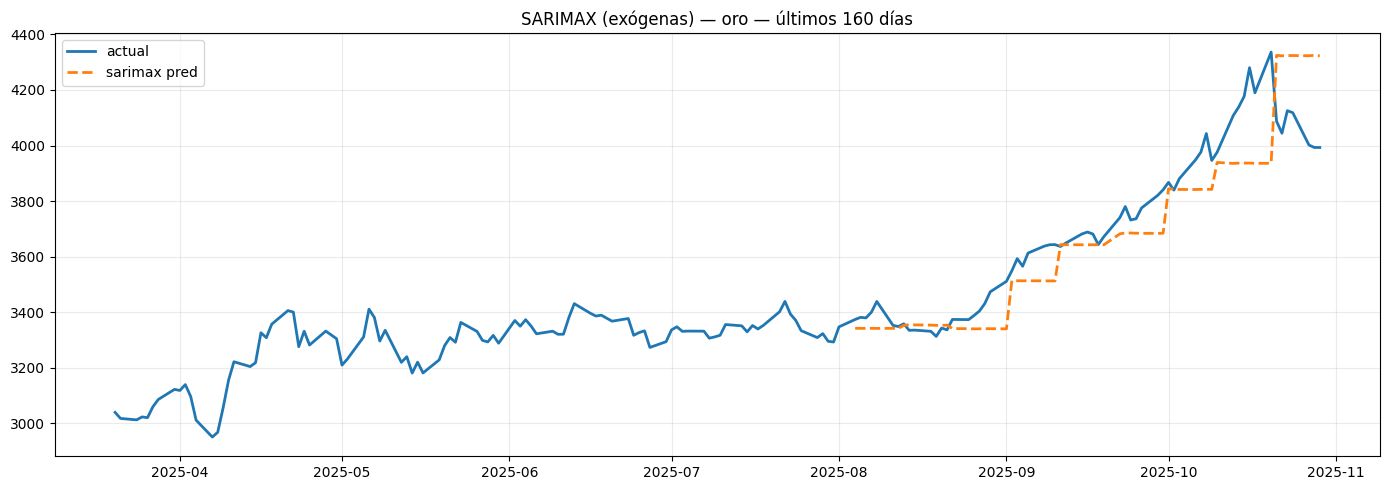

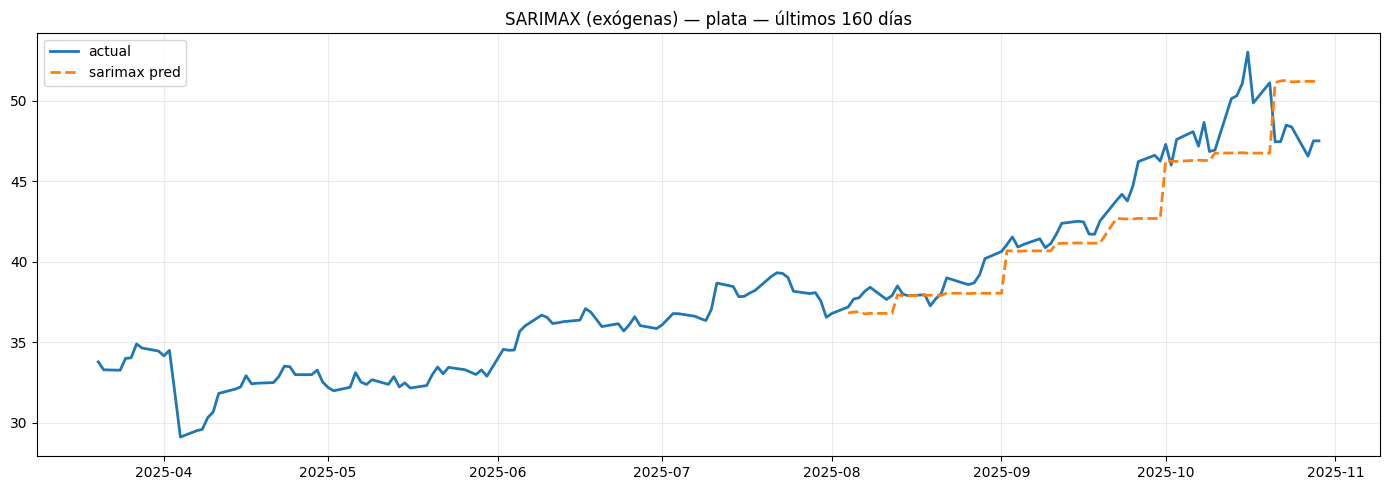

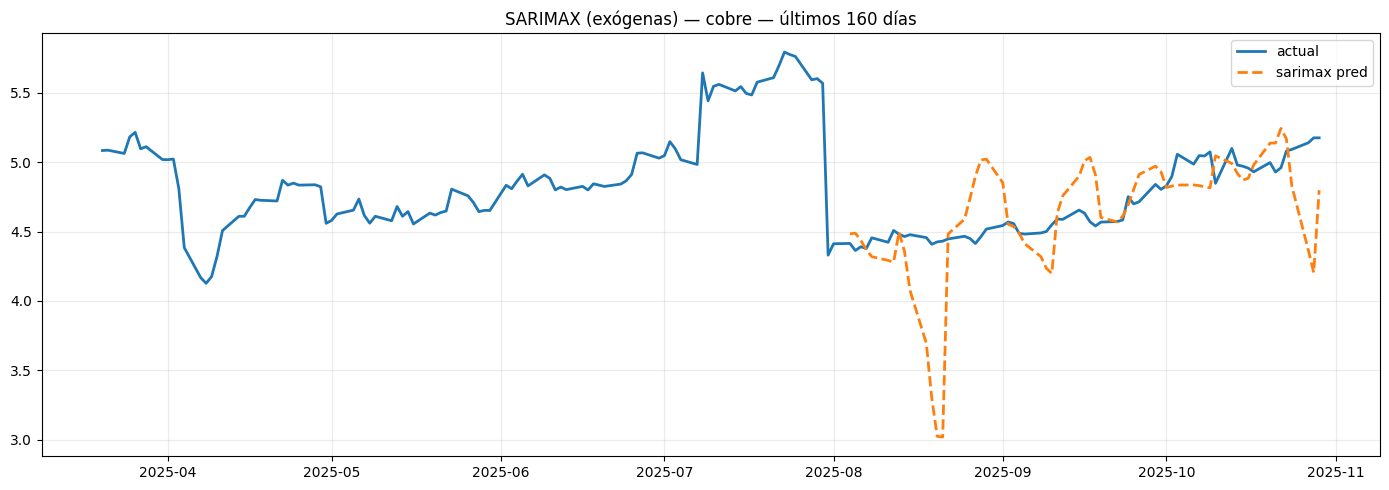

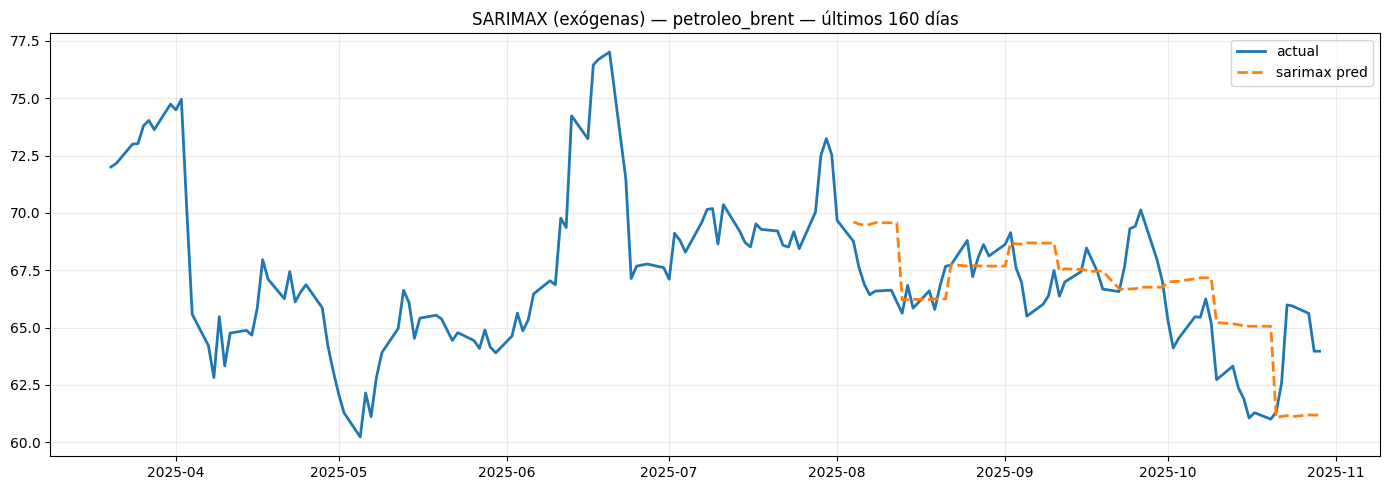

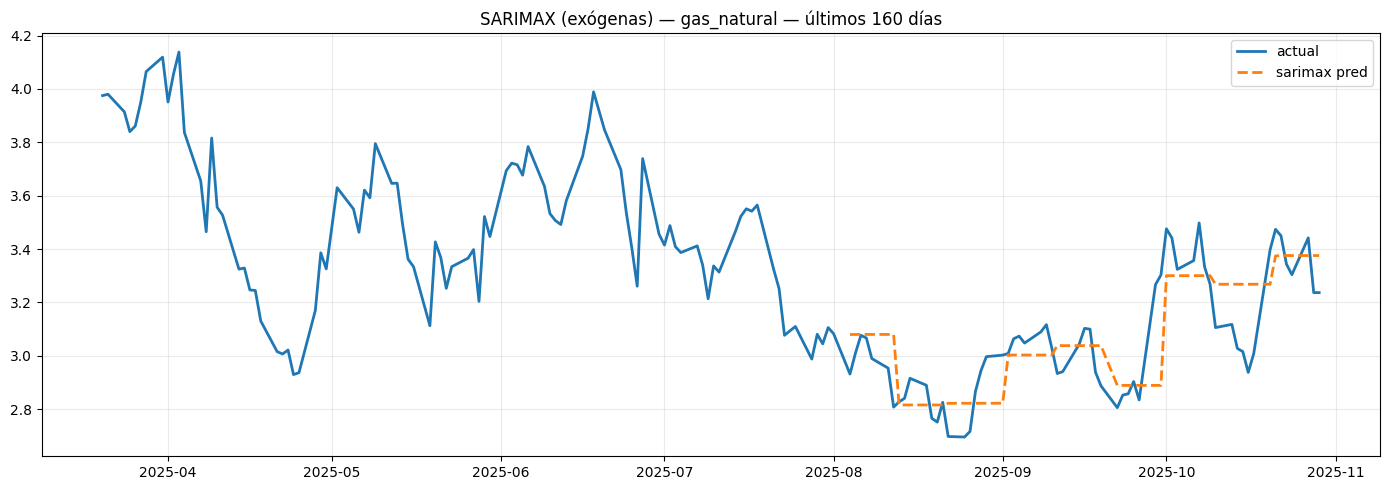

In [ ]:
# =========================
# predicción SARIMAX (por asset) 
# =========================

def plot_sarimax_prediction(asset: str, df_full: pd.DataFrame, df_daily_pred: pd.DataFrame, n_last: int = 160):
    s = df_full[asset].dropna().iloc[-n_last:]

    p = (
        df_daily_pred[df_daily_pred["asset"] == asset]
        .set_index("timestamp")
        .sort_index()
    )

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(s.index, s.values, label="actual", linewidth=2)

    # sólo predicciones en el tramo test (últimos 63)
    p_test = p.loc[p.index.intersection(df_consol_test.index)]
    if len(p_test) > 0:
        ax.plot(p_test.index, p_test["y_pred"].values, linestyle="--", linewidth=2, label="sarimax pred")

    ax.set_title(f"SARIMAX (exógenas) — {asset} — últimos {n_last} días")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.tight_layout()
    plt.show()

for a in TARGET_COLS:
    plot_sarimax_prediction(a, df_full, df_sarimax_daily, n_last=160)


In [ ]:
DEVICE = torch.device("cuda")

def set_seed_torch(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

class MultiOutSeqDataset(Dataset):
    def __init__(self, X_seq: np.ndarray, Y_seq: np.ndarray):
        self.X = torch.tensor(X_seq, dtype=torch.float32)
        self.Y = torch.tensor(Y_seq, dtype=torch.float32)
    def __len__(self) -> int:
        return self.X.shape[0]
    def __getitem__(self, idx: int):
        return self.X[idx], self.Y[idx]

class MultiOutLSTM(nn.Module):
    def __init__(self, input_dim: int, n_assets: int, horizon: int,
                 hidden_size: int = 128, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False,
        )
        self.drop = nn.Dropout(dropout)
        self.heads = nn.ModuleList([nn.Linear(hidden_size, horizon) for _ in range(n_assets)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)
        h = self.drop(out[:, -1, :])
        yhat = torch.stack([head(h) for head in self.heads], dim=1)
        return yhat  # (B, A, H)

def _build_supervised_sequences(X: np.ndarray, Y: np.ndarray, lookback: int, horizon: int):
    X_seq, Y_seq = [], []
    T = len(X)
    for t in range(lookback, T - horizon + 1):
        X_seq.append(X[t - lookback:t, :])
        Y_seq.append(Y[t:t + horizon, :].T)  # (A, H)
    return np.asarray(X_seq), np.asarray(Y_seq)

def _train_one_model(X_train_seq: np.ndarray, Y_train_seq: np.ndarray, input_dim: int, n_assets: int, horizon: int, cfg: dict, seed: int):
    set_seed_torch(seed)
    ds = MultiOutSeqDataset(X_train_seq, Y_train_seq)
    dl = DataLoader(ds, batch_size=cfg["batch_size"], shuffle=True, drop_last=False)

    model = MultiOutLSTM(
        input_dim=input_dim,
        n_assets=n_assets,
        horizon=horizon,
        hidden_size=cfg["hidden_size"],
        num_layers=cfg["num_layers"],
        dropout=cfg["dropout"],
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(cfg["epochs"]):
        for xb, yb in dl:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

    return model

def _predict_block(model: nn.Module, X_context: np.ndarray) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        xb = torch.tensor(X_context[None, :, :], dtype=torch.float32, device=DEVICE)
        yhat = model(xb).detach().cpu().numpy()[0]
    return yhat  # (A, H)

# Config LSTM 
LSTM_CFG = dict(
    lookback=28,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    lr=1e-3,
    weight_decay=0.0,
    batch_size=64,
    epochs=40,
)

SEEDS_TEST = (42,)  

def evaluate_lstm_rolling(df_full: pd.DataFrame, target_cols: List[str], cfg: dict, seeds: Tuple[int, ...]):
    # features numéricas
    num_cols = [c for c in df_full.columns if pd.api.types.is_numeric_dtype(df_full[c])]
    X_cols = list(num_cols)

    dfX = df_full[X_cols].replace([np.inf, -np.inf], np.nan).ffill().bfill()
    dfY = df_full[target_cols].astype(float)

    # ---------- Escalado X ----------
    x_scaler = StandardScaler()
    x_scaler.fit(dfX.iloc[:len(df_consol_train)].values)
    X_all = x_scaler.transform(dfX.values)

    # ---------- Escalado Y (FIX) ----------
    y_scaler = StandardScaler()
    y_scaler.fit(dfY.iloc[:len(df_consol_train)].values)
    Y_all = y_scaler.transform(dfY.values)   # <-  targets escalados

    rows = []
    for window_id, date_range, df_tr, df_te in iter_rolling_windows(df_full, test_days=TEST_DAYS, pred_len=PRED_LEN):
        end_train = len(df_tr)
        end_test = end_train + PRED_LEN

        if end_train < max(MIN_TRAIN, cfg["lookback"] + cfg["lookback"]):
            continue

        X_tr = X_all[:end_train]
        Y_tr = Y_all[:end_train]

        X_seq, Y_seq = _build_supervised_sequences(X_tr, Y_tr, lookback=cfg["lookback"], horizon=PRED_LEN)
        if len(X_seq) == 0:
            continue

        preds_seeds = []
        for seed in seeds:
            model = _train_one_model(
                X_train_seq=X_seq,
                Y_train_seq=Y_seq,
                input_dim=X_seq.shape[-1],
                n_assets=len(target_cols),
                horizon=PRED_LEN,
                cfg=cfg,
                seed=seed,
            )
            X_context = X_all[end_train - cfg["lookback"]:end_train]
            preds_seeds.append(_predict_block(model, X_context))  # (A,H) en escala Y

        yhat_scaled = np.mean(np.stack(preds_seeds, axis=0), axis=0)  # (A, H) escalado

        # ---------- Inversa escala Y (FIX) ----------
        # StandardScaler espera (n_samples, n_features). Convertimos (A,H) -> (H,A), invertimos y devolvemos (A,H)
        yhat_mean = y_scaler.inverse_transform(yhat_scaled.T).T  # (A, H) en escala original

        ts_index = df_full.index[end_train:end_test]


        base_ts = df_full.index[end_train-1]
        y_base_vec = df_full.loc[base_ts, target_cols].values  # (A,)
        y_true_block = df_full.loc[ts_index, target_cols].values  # (H, A)

        for a_i, asset in enumerate(target_cols):
            for h_i, ts in enumerate(ts_index):
                rows.append({
                    "asset": asset,
                    "window_id": window_id,
                    "date_range": date_range,
                    "timestamp": ts,
                    "y_true": float(y_true_block[h_i, a_i]),
                    "y_pred": float(yhat_mean[a_i, h_i]),
                    "y_base": float(y_base_vec[a_i]),
                })

    df_daily = pd.DataFrame(rows).sort_values(["asset", "timestamp"]).reset_index(drop=True)

    metrics_rows = []
    for asset in target_cols:
        s = df_daily[df_daily["asset"] == asset].set_index("timestamp").sort_index()
        metrics_rows.append({
            "asset": asset,
            "Ratio Direccional": directional_ratio_base(s["y_true"], s["y_pred"], s["y_base"]),
            "MAPE": mape(s["y_true"], s["y_pred"]),
            "RMSE": rmse(s["y_true"], s["y_pred"]),
        })
    df_metrics = pd.DataFrame(metrics_rows).sort_values("asset").reset_index(drop=True)

    return df_daily, df_metrics

df_lstm_daily, df_lstm_metrics = evaluate_lstm_rolling(df_full, TARGET_COLS, LSTM_CFG, seeds=SEEDS_TEST)
df_lstm_metrics

,asset,Ratio Direccional,MAPE,RMSE
0,cobre,47.619048,6.881466,0.445594
1,gas_natural,44.444444,9.032975,0.327007
2,oro,26.984127,4.901009,223.059025
3,petroleo_brent,58.730159,3.369960,2.776390
4,plata,28.571429,6.094640,3.312406


In [ ]:
# =========================
# AutoGluon TimeSeries — evaluación rolling origin (63 días)
# =========================
RUN_AUTOGLUON = True  

AG_PRESETS = ["fast_training", "chronos2"]
AG_BASE_PATH = str(getattr(config, "PROJ_ROOT", config.PROCESSED_DATA_DIR).resolve() / "autogluon_models_63d")
os.makedirs(AG_BASE_PATH, exist_ok=True)

def _ag_predict_for_models(predictor: TimeSeriesPredictor,
                           train_data: TimeSeriesDataFrame,
                           known_cov: Optional[TimeSeriesDataFrame],
                           model_names: List[str]):
    """
    Retorna dict {model_name: Series(pred_mean)}.
    Si tu versión no soporta model= en predictor.predict, cae a BEST_MODEL_ONLY.
    """
    preds = {}
    for m in model_names:
        try:
            pred = predictor.predict(train_data, known_covariates=known_cov, model=m) if known_cov is not None else predictor.predict(train_data, model=m)
        except TypeError:
            pred = predictor.predict(train_data, known_covariates=known_cov) if known_cov is not None else predictor.predict(train_data)
            preds["BEST_MODEL_ONLY"] = pred["mean"].copy()
            return preds
        preds[m] = pred["mean"].copy()
    return preds

def evaluate_autogluon_rolling(df_full: pd.DataFrame, assets: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    rows_daily = []

    for asset in assets:
        for preset in AG_PRESETS:
            for window_id, date_range, df_tr, df_te in iter_rolling_windows(df_full, test_days=TEST_DAYS, pred_len=PRED_LEN):
                if len(df_tr) < MIN_TRAIN:
                    continue

                exog_cols = _select_exog_cols(df_tr, asset, max_exog=MAX_EXOG)
                exog_cols = [c for c in exog_cols if c in df_te.columns]

                cols = [asset] + exog_cols
                df_train = df_tr[cols].copy().reset_index()
                df_train.columns = ["timestamp"] + cols
                df_train["item_id"] = asset

                df_test = df_te[cols].copy().reset_index()
                df_test.columns = ["timestamp"] + cols
                df_test["item_id"] = asset

                train_data = TimeSeriesDataFrame.from_data_frame(df_train, id_column="item_id", timestamp_column="timestamp")

                known_cov = None
                if len(exog_cols) > 0:
                    # --- construir FUTURAS exógenas de forma naive usando SOLO train ---
                    X_future_df = _make_future_exog_from_train(
                        df_tr, exog_cols, df_te.index, method=FUTURE_EXOG_METHOD  # "last" 
                    )
                    if isinstance(X_future_df.index, pd.DatetimeIndex):
                        X_future_df = X_future_df.copy()
                        X_future_df["timestamp"] = X_future_df.index

                    X_future_df["item_id"] = asset
                    known_cov = TimeSeriesDataFrame.from_data_frame(
                        X_future_df[["item_id", "timestamp"] + exog_cols],
                        id_column="item_id",
                        timestamp_column="timestamp",
                    )

                model_path = os.path.join(AG_BASE_PATH, preset, asset, f"w{window_id:02d}")
                if os.path.exists(model_path):
                    shutil.rmtree(model_path, ignore_errors=True)

                predictor = TimeSeriesPredictor(
                    target=asset,
                    prediction_length=PRED_LEN,
                    eval_metric="MAPE",
                    known_covariates_names=exog_cols if len(exog_cols) > 0 else None,
                    path=model_path,
                    verbosity=0,
                ).fit(train_data, presets=preset)

                # modelos internos
                try:
                    lb = predictor.leaderboard(data=train_data, silent=True)
                    model_names = list(lb["model"].values)
                except Exception:
                    model_names = []
                if len(model_names) == 0:
                    model_names = ["BEST_MODEL_ONLY"]

                preds_by_model = _ag_predict_for_models(predictor, train_data, known_cov, model_names)

                y_true = pd.to_numeric(df_te[asset], errors="coerce").values
                ts_index = df_te.index
    
                y_base_scalar = float(pd.to_numeric(df_tr[asset], errors="coerce").dropna().iloc[-1])
                for mname, y_pred_series in preds_by_model.items():
                    y_pred = y_pred_series.values.astype(float).reshape(-1)
                    for i, ts in enumerate(ts_index):
                        rows_daily.append({
                            "asset": asset,
                            "preset": preset,
                            "model": mname,
                            "window_id": window_id,
                            "date_range": date_range,
                            "timestamp": ts,
                            "y_true": float(y_true[i]),
                            "y_pred": float(y_pred[i]),
                            "y_base": y_base_scalar,
                        })

    df_daily = pd.DataFrame(rows_daily).sort_values(["asset", "preset", "model", "timestamp"]).reset_index(drop=True)

    metrics_rows = []
    for (asset, preset, model), g in df_daily.groupby(["asset", "preset", "model"], sort=False):
        s = g.set_index("timestamp").sort_index()
        metrics_rows.append({
            "asset": asset,
            "preset": preset,
            "model": model,
            "Ratio Direccional": directional_ratio_base(s["y_true"], s["y_pred"], s["y_base"]),
            "MAPE": mape(s["y_true"], s["y_pred"]),
            "RMSE": rmse(s["y_true"], s["y_pred"]),
        })
    df_metrics = pd.DataFrame(metrics_rows).sort_values(["asset", "MAPE"]).reset_index(drop=True)

    df_best = (
        df_metrics.sort_values(["asset", "MAPE"], ascending=[True, True])
                 .groupby("asset", as_index=False)
                 .first()
                 .rename(columns={"preset": "AG_preset", "model": "AG_model",
                                  "Ratio Direccional": "AG_Ratio Direccional",
                                  "MAPE": "AG_MAPE",
                                  "RMSE": "AG_RMSE"})
    )
    return df_daily, df_metrics, df_best


df_ag_daily = df_ag_metrics = df_ag_best = None
if RUN_AUTOGLUON and _HAS_AUTOGLUON:
    df_ag_daily, df_ag_metrics, df_ag_best = evaluate_autogluon_rolling(df_full, TARGET_COLS)
    df_ag_metrics.head(25)

In [ ]:
# =========================
# Comparación final 
# =========================
df_compare = (
    df_sarimax_metrics.rename(columns={
        "Ratio Direccional": "SARIMAX_Ratio Direccional",
        "MAPE": "SARIMAX_MAPE",
        "RMSE": "SARIMAX_RMSE",
    })
    .merge(
        df_naive_metrics.rename(columns={
            "Ratio Direccional": "NAIVE_Ratio Direccional",
            "MAPE": "NAIVE_MAPE",
            "RMSE": "NAIVE_RMSE",
        }),
        on="asset",
        how="inner"
    )
    .merge(
        df_lstm_metrics.rename(columns={
            "Ratio Direccional": "LSTM_Ratio Direccional",
            "MAPE": "LSTM_MAPE",
            "RMSE": "LSTM_RMSE",
        }),
        on="asset",
        how="inner"
    )
)

if df_ag_best is not None:
    df_compare = df_compare.merge(df_ag_best, on="asset", how="left")

df_compare

,asset,SARIMAX_Ratio Direccional,SARIMAX_MAPE,SARIMAX_RMSE,NAIVE_Ratio Direccional,NAIVE_MAPE,NAIVE_RMSE,LSTM_Ratio Direccional,LSTM_MAPE,LSTM_RMSE,AG_preset,AG_model,AG_Ratio Direccional,AG_MAPE,AG_RMSE
0,cobre,73.015873,5.583831,0.401734,0.0,1.790175,0.114056,47.619048,6.881466,0.445594,fast_training,ETS,49.206349,1.790165,0.114056
1,gas_natural,61.904762,3.491973,0.138796,0.0,3.515018,0.139314,44.444444,9.032975,0.327007,fast_training,Naive,0.000000,3.515018,0.139314
2,oro,57.142857,2.692491,144.725366,0.0,2.731076,146.957286,26.984127,4.901009,223.059025,fast_training,WeightedEnsemble,71.428571,2.507366,132.123164
3,petroleo_brent,68.253968,2.691804,2.187938,0.0,2.748249,2.244665,58.730159,3.369960,2.776390,chronos2,Chronos2,58.730159,2.724684,2.241719
4,plata,66.666667,3.576691,2.177930,0.0,3.608309,2.170269,28.571429,6.094640,3.312406,chronos2,Chronos2,53.968254,3.411656,2.008673
